In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import json
import os

In [2]:
pd.__version__

u'0.24.1'

In [3]:
def load_tweets(path):
   
    with open(path, "r") as f:
        example_tweets = json.load(f)
        
    return example_tweets

Grab Invoca's tweets

In [4]:
tweets = load_tweets('tweetDemo.json')
print "Number of tweets downloaded:", len(tweets)

Number of tweets downloaded: 3216


Tweets come as a list of nested dictionaries -- a JSON. These are great for giving context to data (metadeta).

In [5]:
tweets[0]

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Mon Feb 25 16:45:17 +0000 2019',
 u'display_text_range': [0, 125],
 u'entities': {u'hashtags': [{u'indices': [44, 63],
    u'text': u'customerexperience'},
   {u'indices': [65, 68], u'text': u'CX'},
   {u'indices': [69, 77], u'text': u'martech'},
   {u'indices': [78, 100], u'text': u'digitaltransformation'}],
  u'symbols': [],
  u'urls': [{u'display_url': u'cmo.com/interviews/art\u2026',
    u'expanded_url': u'https://www.cmo.com/interviews/articles/2019/2/14/nextgeneration-cx-will-count-on-these-technologies-summit19.html#gs.qYT6LaUv',
    u'indices': [102, 125],
    u'url': u'https://t.co/BBPEyqHxsQ'}],
  u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'full_text': u'What technologies are shaping the future of #customerexperience?\n#CX #martech #digitaltransformation\n\nhttps://t.co/BBPEyqHxsQ',
 u'geo': None,
 u'id': 1100074264768712709,
 u'id_str': u'1100074264768712709',
 u'in_reply_to_screen_na

In [6]:
tweets[0].keys()

[u'full_text',
 u'truncated',
 u'is_quote_status',
 u'in_reply_to_status_id',
 u'id',
 u'favorite_count',
 u'contributors',
 u'source',
 u'retweeted',
 u'coordinates',
 u'entities',
 u'in_reply_to_screen_name',
 u'id_str',
 u'display_text_range',
 u'retweet_count',
 u'in_reply_to_user_id',
 u'favorited',
 u'user',
 u'geo',
 u'in_reply_to_user_id_str',
 u'possibly_sensitive',
 u'lang',
 u'created_at',
 u'in_reply_to_status_id_str',
 u'place']

In [7]:
for i in range(5):
    print tweets[i]['full_text'] + '\n'    

What technologies are shaping the future of #customerexperience?
#CX #martech #digitaltransformation

https://t.co/BBPEyqHxsQ

A #throwback to part of the Invoca Summit dream team enjoying the best event of the year. Have you saved the date for 2019? ➡️https://t.co/Zid5ZapNQa ⬅️ 
#marketingevent #digitalmarketing #marketinganalytics https://t.co/QZreYFXZQm

See how Clearlink was able to reduce customer service calls by 20% by improving the online customer experience. 
#digitalmarketing #landingpageoptimization #customerexperience

https://t.co/HSWOUtxoa5

#Retro tech lovers can relax, this isn't a new flip phone. But you #phablet lovers are going to want to see the new @SamsungMobile folding #phone. #mobile https://t.co/iGap0O67Sm

Today's the first day of the 3-day #hackathon hosted at Invoca! It'll be a time full of hacking, good food, talks, and prizes. 
#engineeringhackathon #socialengineering
https://t.co/UdhjzROoSz



In [8]:
tweets[0]['entities']

{u'hashtags': [{u'indices': [44, 63], u'text': u'customerexperience'},
  {u'indices': [65, 68], u'text': u'CX'},
  {u'indices': [69, 77], u'text': u'martech'},
  {u'indices': [78, 100], u'text': u'digitaltransformation'}],
 u'symbols': [],
 u'urls': [{u'display_url': u'cmo.com/interviews/art\u2026',
   u'expanded_url': u'https://www.cmo.com/interviews/articles/2019/2/14/nextgeneration-cx-will-count-on-these-technologies-summit19.html#gs.qYT6LaUv',
   u'indices': [102, 125],
   u'url': u'https://t.co/BBPEyqHxsQ'}],
 u'user_mentions': []}

In [9]:
tweets[0]['user']

{u'contributors_enabled': False,
 u'created_at': u'Fri May 22 13:37:03 +0000 2009',
 u'default_profile': False,
 u'default_profile_image': False,
 u'description': u'AI-Powered Call Tracking and Analytics for Marketers',
 u'entities': {u'description': {u'urls': []},
  u'url': {u'urls': [{u'display_url': u'Invoca.com',
     u'expanded_url': u'https://www.Invoca.com',
     u'indices': [0, 23],
     u'url': u'https://t.co/Q9CRhBGXWZ'}]}},
 u'favourites_count': 3545,
 u'follow_request_sent': False,
 u'followers_count': 4133,
 u'following': False,
 u'friends_count': 1296,
 u'geo_enabled': True,
 u'has_extended_profile': False,
 u'id': 41812611,
 u'id_str': u'41812611',
 u'is_translation_enabled': False,
 u'is_translator': False,
 u'lang': u'en',
 u'listed_count': 728,
 u'location': u'Santa Barbara, CA',
 u'name': u'Invoca',
 u'notifications': False,
 u'profile_background_color': u'FFFFFF',
 u'profile_background_image_url': u'http://abs.twimg.com/images/themes/theme1/bg.png',
 u'profile_backg

In [10]:
df = pd.read_json('tweetDemo.json')
df.head(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2019-02-25 16:45:17,"[0, 125]","{u'symbols': [], u'user_mentions': [], u'hasht...",NaN,0,False,What technologies are shaping the future of #c...,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."
1,NaN,NaN,2019-02-22 23:45:02,"[0, 207]","{u'symbols': [], u'user_mentions': [], u'hasht...",{u'media': [{u'expanded_url': u'https://twitte...,2,False,A #throwback to part of the Invoca Summit drea...,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."
2,NaN,NaN,2019-02-22 19:52:01,"[0, 200]","{u'symbols': [], u'user_mentions': [], u'hasht...",NaN,0,False,See how Clearlink was able to reduce customer ...,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."
3,NaN,NaN,2019-02-22 17:54:31,"[0, 178]","{u'symbols': [], u'user_mentions': [{u'indices...",NaN,0,False,"#Retro tech lovers can relax, this isn't a new...",NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,"{u'follow_request_sent': False, u'has_extended..."
4,NaN,NaN,2019-02-22 16:45:05,"[0, 192]","{u'symbols': [], u'user_mentions': [], u'hasht...",NaN,1,False,Today's the first day of the 3-day #hackathon ...,NaN,...,NaN,NaN,NaN,NaN,1,False,NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 31 columns):
contributors                 0 non-null float64
coordinates                  0 non-null float64
created_at                   3216 non-null datetime64[ns]
display_text_range           3216 non-null object
entities                     3216 non-null object
extended_entities            819 non-null object
favorite_count               3216 non-null int64
favorited                    3216 non-null bool
full_text                    3216 non-null object
geo                          0 non-null float64
id                           3216 non-null int64
id_str                       3216 non-null int64
in_reply_to_screen_name      55 non-null object
in_reply_to_status_id        42 non-null float64
in_reply_to_status_id_str    42 non-null float64
in_reply_to_user_id          55 non-null float64
in_reply_to_user_id_str      55 non-null float64
is_quote_status              3216 non-null bool
lang 

In [12]:
overview = df.describe()
overview

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,3216.000000,0.0,3.216000e+03,3.216000e+03,4.200000e+01,4.200000e+01,5.500000e+01,5.500000e+01,2848.0,5.600000e+01,5.600000e+01,3216.000000
mean,NaN,NaN,0.559080,NaN,8.486042e+17,8.486042e+17,8.796323e+17,8.796323e+17,1.526071e+16,1.526071e+16,0.0,9.396747e+17,9.396747e+17,1.230100
std,NaN,NaN,1.087577,NaN,9.991030e+16,9.991030e+16,1.093372e+17,1.093372e+17,1.131764e+17,1.131764e+17,0.0,1.063520e+17,1.063520e+17,7.728353
min,NaN,NaN,0.000000,NaN,7.355309e+17,7.355309e+17,7.435340e+17,7.435340e+17,7.022662e+06,7.022662e+06,0.0,7.402981e+17,7.402981e+17,0.000000
25%,NaN,NaN,0.000000,NaN,7.753596e+17,7.753596e+17,7.788856e+17,7.788856e+17,1.700855e+07,1.700855e+07,0.0,8.502970e+17,8.502970e+17,0.000000
50%,NaN,NaN,0.000000,NaN,8.084416e+17,8.084416e+17,8.309495e+17,8.309495e+17,4.181261e+07,4.181261e+07,0.0,9.784503e+17,9.784503e+17,0.000000
75%,NaN,NaN,1.000000,NaN,9.135332e+17,9.135332e+17,9.639338e+17,9.639338e+17,3.599900e+08,3.599900e+08,0.0,1.006657e+18,1.006657e+18,1.000000
max,NaN,NaN,12.000000,NaN,1.100074e+18,1.100074e+18,1.091022e+18,1.091022e+18,8.393388e+17,8.393388e+17,0.0,1.085549e+18,1.085549e+18,188.000000


In [13]:
df.columns

Index([u'contributors', u'coordinates', u'created_at', u'display_text_range',
       u'entities', u'extended_entities', u'favorite_count', u'favorited',
       u'full_text', u'geo', u'id', u'id_str', u'in_reply_to_screen_name',
       u'in_reply_to_status_id', u'in_reply_to_status_id_str',
       u'in_reply_to_user_id', u'in_reply_to_user_id_str', u'is_quote_status',
       u'lang', u'place', u'possibly_sensitive', u'quoted_status',
       u'quoted_status_id', u'quoted_status_id_str',
       u'quoted_status_permalink', u'retweet_count', u'retweeted',
       u'retweeted_status', u'source', u'truncated', u'user'],
      dtype='object')

In [14]:
df.head(1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2019-02-25 16:45:17,"[0, 125]","{u'symbols': [], u'user_mentions': [], u'hasht...",NaN,0,False,What technologies are shaping the future of #c...,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."


In [15]:
df['contributors'].isna().head()

0    True
1    True
2    True
3    True
4    True
Name: contributors, dtype: bool

In [16]:
nanThreshhold = 0.5

columnstoKeep = [col for col in df.columns if np.mean(df[col].isna()) < nanThreshhold]
columnstoKeep

[u'created_at',
 u'display_text_range',
 u'entities',
 u'favorite_count',
 u'favorited',
 u'full_text',
 u'id',
 u'id_str',
 u'is_quote_status',
 u'lang',
 u'possibly_sensitive',
 u'retweet_count',
 u'retweeted',
 u'source',
 u'truncated',
 u'user']

To make code predictable, make copies of your dataframe if you're going to work on some subset of them.

In [17]:
truncatedDf = df.copy().loc[:, columnstoKeep]
print truncatedDf.shape

truncatedDf.head()

(3216, 16)


,created_at,display_text_range,entities,favorite_count,favorited,full_text,id,id_str,is_quote_status,lang,possibly_sensitive,retweet_count,retweeted,source,truncated,user
0,2019-02-25 16:45:17,"[0, 125]","{u'symbols': [], u'user_mentions': [], u'hasht...",0,False,What technologies are shaping the future of #c...,1100074264768712709,1100074264768712704,False,en,0.0,0,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."
1,2019-02-22 23:45:02,"[0, 207]","{u'symbols': [], u'user_mentions': [], u'hasht...",2,False,A #throwback to part of the Invoca Summit drea...,1099092732801413120,1099092732801413120,False,en,0.0,0,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."
2,2019-02-22 19:52:01,"[0, 200]","{u'symbols': [], u'user_mentions': [], u'hasht...",0,False,See how Clearlink was able to reduce customer ...,1099034091465388032,1099034091465388032,False,en,0.0,0,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."
3,2019-02-22 17:54:31,"[0, 178]","{u'symbols': [], u'user_mentions': [{u'indices...",0,False,"#Retro tech lovers can relax, this isn't a new...",1099004523899547649,1099004523899547648,False,en,0.0,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,"{u'follow_request_sent': False, u'has_extended..."
4,2019-02-22 16:45:05,"[0, 192]","{u'symbols': [], u'user_mentions': [], u'hasht...",1,False,Today's the first day of the 3-day #hackathon ...,1098987050433503232,1098987050433503232,False,en,0.0,1,False,"<a href=""https://sproutsocial.com"" rel=""nofoll...",False,"{u'follow_request_sent': False, u'has_extended..."


In [18]:
assert truncatedDf['id'].value_counts().mean() == 1
assert truncatedDf['id_str'].value_counts().mean() == 1

# or, simply,
assert truncatedDf['id'].is_unique
assert truncatedDf['id_str'].is_unique

# if these assert statements get triggered, use df.drop_duplicates() on the primary key columns

In [19]:
truncatedDf['source'].value_counts()

<a href="https://sproutsocial.com" rel="nofollow">Sprout Social</a>                     2407
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      289
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>       241
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       221
<a href="http://www.linkedin.com/" rel="nofollow">LinkedIn</a>                            38
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>      20
Name: source, dtype: int64

Use https://pythex.org/ to fiddle with regex pattern

Pandas Series string methods: https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html

In [20]:
sourcePattern = r'>(.*)<'

cleanedTag = truncatedDf.loc[:, 'source'].str.extract(sourcePattern, expand=False)

cleanedTag.head()

0         Sprout Social
1         Sprout Social
2         Sprout Social
3    Twitter Web Client
4         Sprout Social
Name: source, dtype: object

Commentary on setting copy warning: https://www.dataquest.io/blog/settingwithcopywarning/
As well as the primary documentation at: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

If you're doing any transformation of the dataframe at all,
- use loc[row label, column] when setting values
- work on copies of your df if you're using a subset.


<img src = 'setCopyWarning.png' >

In [21]:
# dont do this: truncatedDf['parsedSource'] = cleanedTag

truncatedDf.loc[:, 'parsedSource'] = truncatedDf.loc[:, 'source'].str.extract(sourcePattern, expand=False)

truncatedDf = truncatedDf.drop(['source', 'id', 'id_str', 'lang', 
                                'possibly_sensitive', 'is_quote_status', 
                                'display_text_range', 'truncated', 'retweeted'], axis = 1)
truncatedDf.head()

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource
0,2019-02-25 16:45:17,"{u'symbols': [], u'user_mentions': [], u'hasht...",0,False,What technologies are shaping the future of #c...,0,"{u'follow_request_sent': False, u'has_extended...",Sprout Social
1,2019-02-22 23:45:02,"{u'symbols': [], u'user_mentions': [], u'hasht...",2,False,A #throwback to part of the Invoca Summit drea...,0,"{u'follow_request_sent': False, u'has_extended...",Sprout Social
2,2019-02-22 19:52:01,"{u'symbols': [], u'user_mentions': [], u'hasht...",0,False,See how Clearlink was able to reduce customer ...,0,"{u'follow_request_sent': False, u'has_extended...",Sprout Social
3,2019-02-22 17:54:31,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,"#Retro tech lovers can relax, this isn't a new...",0,"{u'follow_request_sent': False, u'has_extended...",Twitter Web Client
4,2019-02-22 16:45:05,"{u'symbols': [], u'user_mentions': [], u'hasht...",1,False,Today's the first day of the 3-day #hackathon ...,1,"{u'follow_request_sent': False, u'has_extended...",Sprout Social


In [22]:
truncatedDf['parsedSource'].value_counts()

Sprout Social          2407
TweetDeck               289
Twitter for iPhone      241
Twitter Web Client      221
LinkedIn                 38
Twitter for Android      20
Name: parsedSource, dtype: int64

In [23]:
%%timeit
# benefits of query are only pronounced at > 200k rows
truncatedDf.query("parsedSource == 'Twitter Web Client' ")

1000 loops, best of 3: 1.64 ms per loop


In [24]:
%%timeit
# this is fine for looking through data or doing calculations
truncatedDf[truncatedDf['parsedSource'] == 'Twitter Web Client']

1000 loops, best of 3: 1.14 ms per loop


In [25]:
%%timeit
# this is the safest way to filter for production
truncatedDf.loc[truncatedDf['parsedSource'] == 'Twitter Web Client']

1000 loops, best of 3: 1.1 ms per loop


In [26]:
%%timeit
truncatedDf.loc[[src == 'Twitter Web Client' for src in truncatedDf['parsedSource'] ]]

1000 loops, best of 3: 1.29 ms per loop


We expect there to be 261 True values when we select for iPhone or Android since there is 241 + 20 of these values in the value_counts call above

In [27]:
phoneOnly = (truncatedDf['parsedSource'] == 'Twitter for iPhone') | (truncatedDf['parsedSource'] == 'Twitter for Android')
assert phoneOnly.sum() == 261

In [28]:
phones = truncatedDf.copy().loc[phoneOnly]
phones.head()

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource
67,2019-01-31 18:39:46,"{u'symbols': [], u'user_mentions': [{u'indices...",1,False,"@Ross_Quintana @JuliaStead Thanks for sharing,...",0,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
99,2019-01-16 21:56:34,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @Chris_Heine: 19% of smart speaker users ac...,1,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
100,2019-01-16 21:56:19,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @WPMediaInsights: CES 2019: Three takeaways...,2,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
129,2018-12-14 13:52:22,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @gregg_johnson: One of my favorite sayings ...,9,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
138,2018-12-08 01:50:19,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @MikeQuindazzi: Humans outperform #AI (#Cha...,32,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone


In [29]:
phones = phones.reset_index(drop=True)
phones.head()

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource
0,2019-01-31 18:39:46,"{u'symbols': [], u'user_mentions': [{u'indices...",1,False,"@Ross_Quintana @JuliaStead Thanks for sharing,...",0,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
1,2019-01-16 21:56:34,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @Chris_Heine: 19% of smart speaker users ac...,1,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
2,2019-01-16 21:56:19,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @WPMediaInsights: CES 2019: Three takeaways...,2,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
3,2018-12-14 13:52:22,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @gregg_johnson: One of my favorite sayings ...,9,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
4,2018-12-08 01:50:19,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @MikeQuindazzi: Humans outperform #AI (#Cha...,32,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone


Accessing data: loc and iloc are only the same when the index is 0, 1, 2, ...

Otherwise loc references the given index, while iloc uses the order of entries (always 0, 1, 2).

In [30]:
phones.loc[[1,3,4]]

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource
1,2019-01-16 21:56:34,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @Chris_Heine: 19% of smart speaker users ac...,1,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
3,2018-12-14 13:52:22,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @gregg_johnson: One of my favorite sayings ...,9,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
4,2018-12-08 01:50:19,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @MikeQuindazzi: Humans outperform #AI (#Cha...,32,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone


In [31]:
phones.iloc[[1,3,4]]

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource
1,2019-01-16 21:56:34,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @Chris_Heine: 19% of smart speaker users ac...,1,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
3,2018-12-14 13:52:22,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @gregg_johnson: One of my favorite sayings ...,9,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone
4,2018-12-08 01:50:19,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @MikeQuindazzi: Humans outperform #AI (#Cha...,32,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone


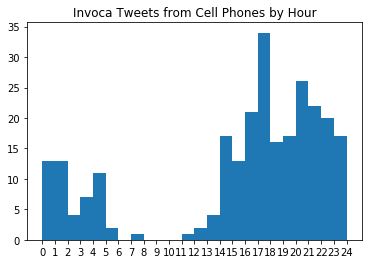

In [32]:
plt.hist(phones.loc[:, 'created_at'].dt.hour, bins=np.arange(25))
plt.xticks(np.arange(25))
plt.title('Invoca Tweets from Cell Phones by Hour');

This plot doesn't make sense -- convert datetime objects to our time zone (Twitter API defaults to UTC -- thanks Google!)

For a review of time series methodology in Pandas, see: https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series

In [33]:
phones.loc[:, 'created_at'] = phones.loc[:, 'created_at'].astype('datetime64[ns]') 

phones.loc[:, 'correctedTime'] = (
                                    phones.loc[:, 'created_at'].dt.tz_localize('UTC')
                                                               .dt.tz_convert('PST8PDT')
                                 )

phones.loc[:, 'hour'] = phones.loc[:, 'correctedTime'].dt.hour
phones.loc[:, 'month'] = phones.loc[:, 'correctedTime'].dt.month
phones.loc[:, 'day'] = phones.loc[:, 'correctedTime'].dt.day
phones.loc[:, 'minute'] = phones.loc[:, 'correctedTime'].dt.minute

/anaconda2/envs/twoSeven/lib/python2.7/site-packages/pandas/core/indexing.py:362: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  self.obj[key] = _infer_fill_value(value)


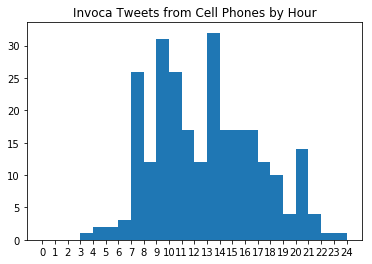

In [34]:
plt.hist(phones['hour'], bins=np.arange(25))
plt.xticks(np.arange(25))
plt.title('Invoca Tweets from Cell Phones by Hour');

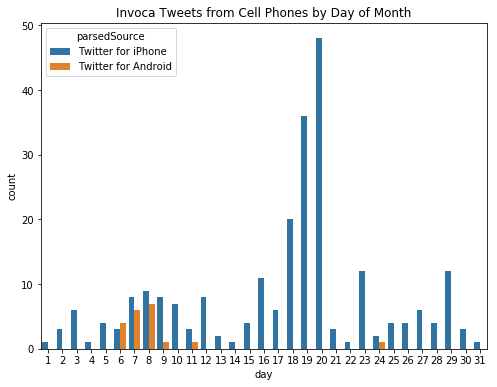

In [35]:
plt.figure(figsize=(8,6))
sns.countplot(x='day', data=phones, hue='parsedSource', )
plt.title('Invoca Tweets from Cell Phones by Day of Month');

see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html

In [36]:
pd.date_range(start='1/1/2018', periods=5, tz='Asia/Tokyo')

DatetimeIndex(['2018-01-01 00:00:00+09:00', '2018-01-02 00:00:00+09:00',
               '2018-01-03 00:00:00+09:00', '2018-01-04 00:00:00+09:00',
               '2018-01-05 00:00:00+09:00'],
              dtype='datetime64[ns, Asia/Tokyo]', freq='D')

What kind of metadeta accompanies these counts?

In [37]:
phones['entities'][10]

{u'hashtags': [],
 u'symbols': [],
 u'urls': [{u'display_url': u'mtech.today/2DsAqjr',
   u'expanded_url': u'https://mtech.today/2DsAqjr',
   u'indices': [97, 120],
   u'url': u'https://t.co/rwauvWY2gy'}],
 u'user_mentions': [{u'id': 747815998531768324L,
   u'id_str': u'747815998531768324',
   u'indices': [3, 17],
   u'name': u'MarTech Today',
   u'screen_name': u'martech_today'},
  {u'id': 1067019368,
   u'id_str': u'1067019368',
   u'indices': [83, 96],
   u'name': u'Barry Levine',
   u'screen_name': u'xBarryLevine'}]}

We can extract the names of mentioned people and groups by looping over our JSON like any other python dictionary

In [38]:
def extractMentions(entities, remove = ['invoca']):
    
    mentions = entities['user_mentions']
    numMentions = len(mentions)
    
    names = []
    
    for i in range(numMentions):
        name = mentions[i]['name'].lower()
        
        if name not in remove:
            names += [name]
            
    return names

In [39]:
extractMentions(phones['entities'][10])

[u'martech today', u'barry levine']

In [40]:
phones.loc[:, 'mentions'] = phones.loc[:, 'entities'].apply(extractMentions)
phones.head(2)

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource,correctedTime,hour,month,day,minute,mentions
0,2019-01-31 18:39:46,"{u'symbols': [], u'user_mentions': [{u'indices...",1,False,"@Ross_Quintana @JuliaStead Thanks for sharing,...",0,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2019-01-31 10:39:46-08:00,10,1,31,39,"[ross quintana #adobesummit, julia stead]"
1,2019-01-16 21:56:34,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @Chris_Heine: 19% of smart speaker users ac...,1,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2019-01-16 13:56:34-08:00,13,1,16,56,"[christopher heine, julia stead]"


In [41]:
# the sum of a series of lists is just one big list
allMentions = phones['mentions'].sum()
print phones['mentions'][:3]
print
print allMentions[:5]

# casting the big list as a series allows us to use pandas functionality
pdMentions = pd.Series(allMentions)
mentionCounts = pdMentions.value_counts()

filteredMentions = mentionCounts[mentionCounts > 2]
filteredMentions

0    [ross quintana #adobesummit, julia stead]
1             [christopher heine, julia stead]
2                            [wpmediainsights]
Name: mentions, dtype: object

[u'ross quintana #adobesummit', u'julia stead', u'christopher heine', u'julia stead', u'wpmediainsights']


gregg johnson          25
julia stead            14
adobe                   8
jim marous              6
dish                    6
ezanga.com              5
crystal marie           5
leslie r. fine          4
facebook                4
laura schierberl        4
marketingcharts         4
salesforce              4
the financial brand     4
david j. maireles       3
kimberly whitler        3
google                  3
i-com global            3
searchmarketingexpo     3
radius                  3
klientboost             3
drips                   3
ringpartner             3
experience cloud        3
dtype: int64

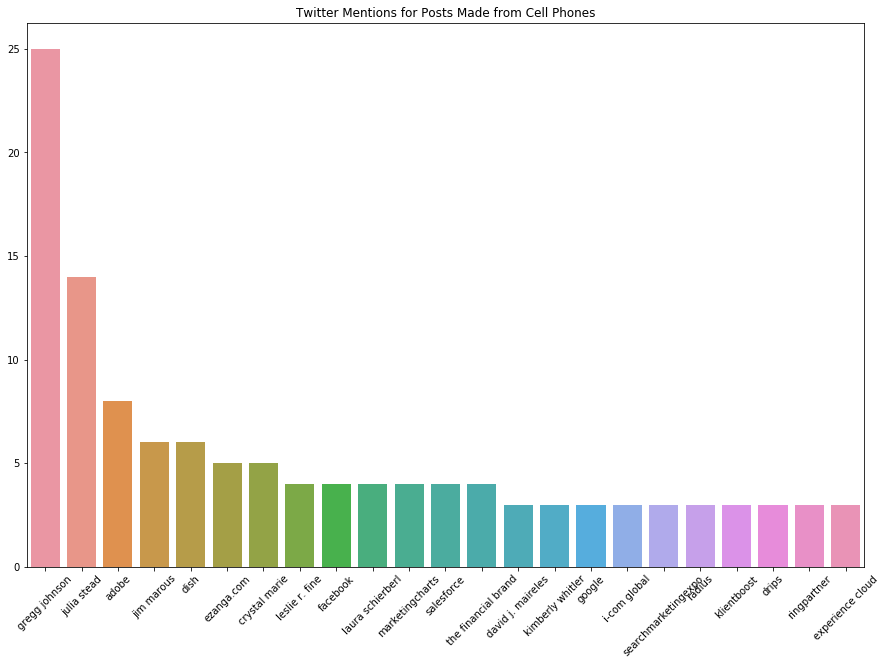

In [42]:
plt.figure(figsize=(15,10))

sns.barplot(x=filteredMentions.index, y=filteredMentions)
plt.title('Twitter Mentions for Posts Made from Cell Phones')
plt.xticks(rotation = 45);

How we do examine the inherent strata within our dataframe? 

One option is to cast our categorical variable as one-hot encoded variables, which is convenient for training ML models.

In [43]:
pd.get_dummies(phones, columns=['parsedSource']).head()

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,correctedTime,hour,month,day,minute,mentions,parsedSource_Twitter for Android,parsedSource_Twitter for iPhone
0,2019-01-31 18:39:46,"{u'symbols': [], u'user_mentions': [{u'indices...",1,False,"@Ross_Quintana @JuliaStead Thanks for sharing,...",0,"{u'follow_request_sent': False, u'has_extended...",2019-01-31 10:39:46-08:00,10,1,31,39,"[ross quintana #adobesummit, julia stead]",0,1
1,2019-01-16 21:56:34,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @Chris_Heine: 19% of smart speaker users ac...,1,"{u'follow_request_sent': False, u'has_extended...",2019-01-16 13:56:34-08:00,13,1,16,56,"[christopher heine, julia stead]",0,1
2,2019-01-16 21:56:19,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @WPMediaInsights: CES 2019: Three takeaways...,2,"{u'follow_request_sent': False, u'has_extended...",2019-01-16 13:56:19-08:00,13,1,16,56,[wpmediainsights],0,1
3,2018-12-14 13:52:22,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @gregg_johnson: One of my favorite sayings ...,9,"{u'follow_request_sent': False, u'has_extended...",2018-12-14 05:52:22-08:00,5,12,14,52,[gregg johnson],0,1
4,2018-12-08 01:50:19,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @MikeQuindazzi: Humans outperform #AI (#Cha...,32,"{u'follow_request_sent': False, u'has_extended...",2018-12-07 17:50:19-08:00,17,12,7,50,"[mike quindazzi ✨, mike quindazzi ✨]",0,1


Making groups with groupby is usually a great place to start for EDA.

(documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)

In [44]:
phones.groupby(['month']).first()

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource,correctedTime,hour,day,minute,mentions
month,,,,,,,,,,,,,
1,2019-01-31 18:39:46,"{u'symbols': [], u'user_mentions': [{u'indices...",1,False,"@Ross_Quintana @JuliaStead Thanks for sharing,...",0,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2019-01-31 10:39:46-08:00,10,31,39,"[ross quintana #adobesummit, julia stead]"
2,2018-02-28 16:03:44,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @FinancialBrand: The Future of #Voice: What...,11,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2018-02-28 08:03:44-08:00,8,28,3,"[the financial brand, jim marous, capgemini]"
3,2018-03-30 18:16:08,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @cindy_zhou: Had a chance to meet @gregg_jo...,4,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2018-03-30 11:16:08-07:00,11,30,16,"[cindy zhou, gregg johnson, nathan ziv]"
4,2018-04-26 15:33:38,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @JesseAdametz: Today I started a new career...,1,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2018-04-26 08:33:38-07:00,8,26,33,[jesse adametz]
5,2018-05-23 23:46:06,"{u'symbols': [], u'user_mentions': [{u'indices...",1,False,"@heatherfoeh Thank you, Heather!",0,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2018-05-23 16:46:06-07:00,16,23,46,[heather foeh]
6,2016-06-23 14:01:44,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @FierceCMO: New report from @Invoca shows t...,1,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2016-06-23 07:01:44-07:00,7,23,1,[fiercecmo]
7,2018-07-18 00:00:48,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @iProspect: Join iProspect’s @JeremyHull an...,3,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2018-07-17 17:00:48-07:00,17,17,0,"[iprospect, jeremy hull, ian dailey]"
8,2018-08-01 19:10:23,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,RT @DG_Report: .@Invoca unveils improved integ...,1,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2018-08-01 12:10:23-07:00,12,1,10,"[demand gen report, google]"
9,2018-09-30 03:07:25,"{u'symbols': [], u'user_mentions': [{u'indices...",0,False,@SpirosMargaris @Adweek Thanks for sharing!,0,"{u'follow_request_sent': False, u'has_extended...",Twitter for iPhone,2018-09-29 20:07:25-07:00,20,29,7,"[spiros margaris, adweek]"


In [45]:
lengths = phones.groupby(['month']).agg(lambda x: len(x) + np.random.normal(scale=20))
lengths

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource,correctedTime,hour,day,minute,mentions
month,,,,,,,,,,,,,
1,40.049939,38.160561,35.967085,40.980715,30.206495,73.283562,35.752739,35.466302,1970-01-01 00:00:00.000000041-08:00,10.515236,50.469202,39.568235,32.954317
2,-7.807793,18.508353,33.624543,24.915050,17.984407,57.842566,-13.911668,26.039105,1970-01-01 00:00:00.000000028-08:00,0.385852,34.862330,60.701394,46.068229
3,4.519543,25.844896,6.390405,27.017830,10.570508,6.707400,6.666145,21.949746,1969-12-31 23:59:59.999999987-08:00,26.792098,-3.429302,3.164092,-3.620502
4,-20.809213,-23.887267,22.212123,-5.873866,8.708511,6.331510,-11.187644,6.830245,1970-01-01 00:00:00.000000004-08:00,-6.861509,13.785520,-2.003919,-13.645427
5,-23.097981,16.588366,-5.761141,8.408787,32.588054,25.438446,-19.633634,-0.582114,1970-01-01 00:00:00.000000010-08:00,-5.673646,-24.043259,40.295833,6.854941
6,-2.033363,-4.469199,-10.731783,27.454643,-3.546489,0.179635,-9.249245,31.997872,1969-12-31 23:59:59.999999991-08:00,8.602346,1.338475,-23.452328,17.992510
7,-2.042628,41.285516,26.185039,22.300409,-16.043301,-7.105968,7.796092,11.554399,1970-01-01 00:00:00.000000020-08:00,30.922549,8.029175,-15.765858,22.568771
8,26.619720,-28.680152,31.503940,23.149538,-0.862478,23.370184,35.841347,-30.732731,1970-01-01 00:00:00.000000020-08:00,17.258723,15.404111,16.527096,-29.809503
9,3.468990,35.765421,15.800104,5.911516,19.097466,48.540300,44.025151,-37.378388,1969-12-31 23:59:59.999999986-08:00,-4.140144,8.138328,44.742651,28.076483


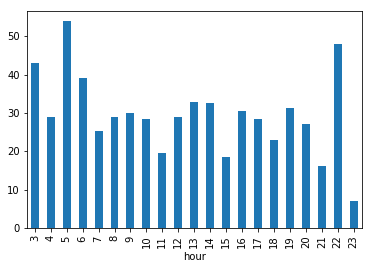

In [46]:
phones.groupby('hour')['minute'].mean().plot(kind='bar')

In [47]:
phones.groupby(['month', 'day']).count().loc[[2, 4], :, :]

created_at  entities  favorite_count  favorited  full_text  \
month day                                                               
2     2             1         1               1          1          1   
      6             2         2               2          2          2   
      8             1         1               1          1          1   
      9             1         1               1          1          1   
      10            2         2               2          2          2   
      12            2         2               2          2          2   
      15            1         1               1          1          1   
      16            2         2               2          2          2   
      19            1         1               1          1          1   
      21            2         2               2          2          2   
      23            1         1               1          1          1   
      27            1         1               1          1          1   
      28            1         1               1          1          1   
4     19            1         1               1          1          1   
      26            1         1               1          1          1   

           retweet_count  user  parsedSource  correctedTime  hour  minute  \
month day                                                                   
2     2                1     1             1              1     1       1   
      6                2     2             2              2     2       2   
      8                1     1             1              1     1       1   
      9                1     1             1              1     1       1   
      10               2     2             2              2     2       2   
      12               2     2             2              2     2       2   
      15               1     1             1              1     1       1   
      16               2     2             2              2     2       2   
      19               1     1             1              1     1       1   
      21               2     2             2              2     2       2   
      23               1     1             1              1     1       1   
      27               1     1             1              1     1       1   
      28               1     1             1              1     1       1   
4     19               1     1             1              1     1       1   
      26               1     1             1              1     1       1   

           mentions  
month day            
2     2           1  
      6           2  
      8           1  
      9           1  
      10          2  
      12          2  
      15          1  
      16          2  
      19          1  
      21          2  
      23          1  
      27          1  
      28          1  
4     19          1  
      26          1

In [48]:
phones.groupby(['month', 'day']).count().loc[(2, 6)]

created_at        2
entities          2
favorite_count    2
favorited         2
full_text         2
retweet_count     2
user              2
parsedSource      2
correctedTime     2
hour              2
minute            2
mentions          2
Name: (2, 6), dtype: int64

In [49]:
phones.groupby(['month']).agg([np.mean, np.std,lambda x: np.sum(x**2)])

favorite_count                    favorited               retweet_count  \
                mean       std <lambda>      mean  std <lambda>          mean   
month                                                                           
1           0.147059  0.435706        7     False  0.0    False      9.470588   
2           0.388889  1.195033       27     False  0.0    False      4.500000   
3           0.000000  0.000000        0     False  0.0    False      4.461538   
4           0.000000  0.000000        0     False  0.0    False      2.500000   
5           0.333333  0.577350        1     False  0.0    False      4.000000   
6           0.000000  0.000000        0     False  0.0    False      2.000000   
7           0.000000  0.000000        0     False  0.0    False      1.375000   
8           0.200000  0.447214        1     False  0.0    False      2.400000   
9           0.272727  0.646670        5     False  0.0    False      1.818182   
10          0.835052  1.598700      313     False  0.0    False      0.835052   
11          1.340426  2.606652      397     False  0.0    False      3.446809   
12          0.055556  0.235702        1     False  0.0    False      4.277778   

                                hour                           day             \
             std <lambda>       mean       std <lambda>       mean        std   
month                                                                           
1      27.175340    27420  11.852941  4.068596     5323  17.294118   8.996731   
2       7.430066     1303  11.611111  4.160584     2721  14.500000   7.461667   
3       6.332659      740  13.538462  5.796772     2786  14.076923   9.114654   
4       2.121320       17  14.000000  8.485281      464  22.500000   4.949747   
5       5.291503      104  14.000000  4.358899      626  20.000000  10.816654   
6       1.224745       26  12.000000  5.049752      822  16.000000   8.124038   
7       1.060660       23  13.250000  5.625198     1626  14.625000   9.148575   
8       2.073644       46  16.000000  6.204837     1434  14.000000  11.135529   
9       2.272364       88  13.000000  5.796551     2195  22.636364   8.500267   
10      1.007063      165  13.113402  3.262400    17702  18.989691   2.659475   
11     10.553813     5682  11.042553  3.519866     6301  12.085106   6.940210   
12      7.314816     1239  11.055556  4.746171     2583  17.055556   7.494878   

                   minute                      
      <lambda>       mean        std <lambda>  
month                                          
1        12840  27.529412  16.867101    35156  
2         4731  29.111111  19.311347    21594  
3         3573  33.615385  20.275348    19623  
4         1037  38.500000   7.778175     3025  
5         1434  41.333333  20.404248     5958  
6         1544  29.400000  26.216407     7071  
7         2297  17.625000  17.775887     4697  
8         1476  25.000000  17.291616     4321  
9         6359  20.272727  17.065116     7433  
10       35658  24.773196  13.560440    77183  
11        9080  32.765957  16.150397    62458  
12        6191  35.555556  14.613540    26386

In [50]:
phones.T

,0,1,2,3,4,5,6,7,8,9,...,251,252,253,254,255,256,257,258,259,260
created_at,2019-01-31 18:39:46,2019-01-16 21:56:34,2019-01-16 21:56:19,2018-12-14 13:52:22,2018-12-08 01:50:19,2018-12-06 15:21:20,2018-11-15 16:55:48,2018-11-15 16:55:02,2018-11-10 21:34:51,2018-11-08 22:33:18,...,2016-07-12 14:01:15,2016-07-12 14:01:08,2016-07-06 01:18:38,2016-07-04 02:23:23,2016-06-23 14:01:44,2016-06-23 14:01:35,2016-06-19 23:54:53,2016-06-11 01:43:24,2016-06-05 19:48:04,2016-05-29 16:19:18
entities,"{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [], u'hasht...",...,"{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices...","{u'symbols': [], u'user_mentions': [{u'indices..."
favorite_count,1,0,0,0,0,0,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
favorited,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
full_text,"@Ross_Quintana @JuliaStead Thanks for sharing,...",RT @Chris_Heine: 19% of smart speaker users ac...,RT @WPMediaInsights: CES 2019: Three takeaways...,RT @gregg_johnson: One of my favorite sayings ...,RT @MikeQuindazzi: Humans outperform #AI (#Cha...,RT @icomglobal: See video of @flashtalking @in...,RT @AdobeExpCloud: Emotions matter to consumer...,@Drips @Adobe Glad you like it!,RT @AdobeExpCloud: Find out how consumers feel...,One of the best things about #invocasummit is ...,...,RT @KlientBoost: 15 + 5 Super Retargeting Idea...,RT @gsterling: Study: 92% of Customer Calls Dr...,Thanks for sharing @k_gabrielsen! 👍🏽,RT @KlientBoost: Do You Know Why Emails And Ca...,RT @FierceCMO: New report from @Invoca shows t...,RT @Mediabids: Newspaper ads drive high intent...,RT @smx: Start optimizing calls with the same ...,RT @eZangaInc: 5 Ways You Can Improve The Cust...,RT @KlientBoost: Learn From The Best: Q&amp;A ...,RT @Digiday: How one company used call intelli...
retweet_count,0,1,2,9,32,3,2,0,2,0,...,1,2,0,1,1,2,4,2,1,2
user,"{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...",...,"{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended...","{u'follow_request_sent': False, u'has_extended..."
parsedSource,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPhone,Twitter for iPho

In [51]:
usefulDF = phones.groupby(['month', 'day']).count().loc[[2, 4], :, :].T
usefulDF

month           2                                      4   
day            2  6  8  9  10 12 15 16 19 21 23 27 28 19 26
created_at      1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
entities        1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
favorite_count  1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
favorited       1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
full_text       1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
retweet_count   1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
user            1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
parsedSource    1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
correctedTime   1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
hour            1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
minute          1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
mentions        1  2  1  1  2  2  1  2  1  2  1  1  1  1  1

In [52]:
usefulDF.to_pickle('savedData.pickle')

In [53]:
!ls

Pandas Deep Dive Rundown.ipynb keys.json
Pandas Draft.ipynb             savedData.pickle
extractMentions.py             setCopyWarning.png
extractMentions.pyc            tweetDemo.json


In [54]:
pd.read_pickle('savedData.pickle')

month           2                                      4   
day            2  6  8  9  10 12 15 16 19 21 23 27 28 19 26
created_at      1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
entities        1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
favorite_count  1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
favorited       1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
full_text       1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
retweet_count   1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
user            1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
parsedSource    1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
correctedTime   1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
hour            1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
minute          1  2  1  1  2  2  1  2  1  2  1  1  1  1  1
mentions        1  2  1  1  2  2  1  2  1  2  1  1  1  1  1

In [55]:
lengths

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource,correctedTime,hour,day,minute,mentions
month,,,,,,,,,,,,,
1,40.049939,38.160561,35.967085,40.980715,30.206495,73.283562,35.752739,35.466302,1970-01-01 00:00:00.000000041-08:00,10.515236,50.469202,39.568235,32.954317
2,-7.807793,18.508353,33.624543,24.915050,17.984407,57.842566,-13.911668,26.039105,1970-01-01 00:00:00.000000028-08:00,0.385852,34.862330,60.701394,46.068229
3,4.519543,25.844896,6.390405,27.017830,10.570508,6.707400,6.666145,21.949746,1969-12-31 23:59:59.999999987-08:00,26.792098,-3.429302,3.164092,-3.620502
4,-20.809213,-23.887267,22.212123,-5.873866,8.708511,6.331510,-11.187644,6.830245,1970-01-01 00:00:00.000000004-08:00,-6.861509,13.785520,-2.003919,-13.645427
5,-23.097981,16.588366,-5.761141,8.408787,32.588054,25.438446,-19.633634,-0.582114,1970-01-01 00:00:00.000000010-08:00,-5.673646,-24.043259,40.295833,6.854941
6,-2.033363,-4.469199,-10.731783,27.454643,-3.546489,0.179635,-9.249245,31.997872,1969-12-31 23:59:59.999999991-08:00,8.602346,1.338475,-23.452328,17.992510
7,-2.042628,41.285516,26.185039,22.300409,-16.043301,-7.105968,7.796092,11.554399,1970-01-01 00:00:00.000000020-08:00,30.922549,8.029175,-15.765858,22.568771
8,26.619720,-28.680152,31.503940,23.149538,-0.862478,23.370184,35.841347,-30.732731,1970-01-01 00:00:00.000000020-08:00,17.258723,15.404111,16.527096,-29.809503
9,3.468990,35.765421,15.800104,5.911516,19.097466,48.540300,44.025151,-37.378388,1969-12-31 23:59:59.999999986-08:00,-4.140144,8.138328,44.742651,28.076483


In [56]:
lengths.corr()

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource,hour,day,minute,mentions
created_at,1.000000,0.439904,0.790216,0.791720,0.757854,0.568635,0.823188,0.621438,0.815984,0.823159,0.695356,0.499881
entities,0.439904,1.000000,0.615832,0.714577,0.523390,0.472834,0.584367,0.639845,0.570401,0.617631,0.579387,0.781607
favorite_count,0.790216,0.615832,1.000000,0.782153,0.708954,0.533355,0.832383,0.705880,0.734032,0.948311,0.769636,0.575091
favorited,0.791720,0.714577,0.782153,1.000000,0.642074,0.516525,0.691194,0.857428,0.836047,0.850273,0.629037,0.655549
full_text,0.757854,0.523390,0.708954,0.642074,1.000000,0.708084,0.585896,0.687643,0.636875,0.737234,0.917240,0.633016
retweet_count,0.568635,0.472834,0.533355,0.516525,0.708084,1.000000,0.480741,0.386398,0.274223,0.660088,0.831782,0.654416
user,0.823188,0.584367,0.832383,0.691194,0.585896,0.480741,1.000000,0.426429,0.628432,0.776461,0.632202,0.414264
parsedSource,0.621438,0.639845,0.705880,0.857428,0.687643,0.386398,0.426429,1.000000,0.757041,0.797812,0.565724,0.696701
hour,0.815984,0.570401,0.734032,0.836047,0.636875,0.274223,0.628432,0.757041,1.000000,0.727098,0.540204,0.492774
day,0.823159,0.617631,0.948311,0.850273,0.737234,0.660088,0.776461,0.797812,0.727098,1.000000,0.767966,0.686613


In [57]:
lengths.cov()

,created_at,entities,favorite_count,favorited,full_text,retweet_count,user,parsedSource,hour,day,minute,mentions
created_at,1164.003109,492.686138,966.069794,600.049527,767.039500,537.825603,972.706975,851.461026,710.561082,1050.434115,979.708783,451.097929
entities,492.686138,1077.631908,724.407761,521.101552,509.701852,430.303276,664.395187,843.527659,477.923094,758.354452,785.446997,678.658335
favorite_count,966.069794,724.407761,1284.017890,622.609660,753.630987,529.825314,1033.033985,1015.795099,671.341221,1270.997052,1138.896294,545.066320
favorited,600.049527,521.101552,622.609660,493.488120,423.134387,318.097736,531.795111,764.937031,474.036127,706.487540,577.068835,385.186615
full_text,767.039500,509.701852,753.630987,423.134387,880.056244,582.331810,601.978950,819.233387,482.227893,818.028534,1123.702470,496.703988
retweet_count,537.825603,430.303276,529.825314,318.097736,582.331810,768.531064,461.581113,430.185120,194.033738,684.447677,952.255010,479.857384
user,972.706975,664.395187,1033.033985,531.795111,601.978950,461.581113,1199.531292,593.118696,555.528701,1005.850237,904.221036,379.498573
parsedSource,851.461026,843.527659,1015.795099,764.937031,819.233387,430.185120,593.118696,1612.794954,775.981693,1198.390253,938.226040,740.054193
hour,710.561082,477.923094,671.341221,474.036127,482.227893,194.033738,555.528701,775.981693,651.456280,694.134631,569.394319,332.673425
day,1050.434115,758.354452,1270.997052,706.487540,818.028534,684.447677,1005.850237,1198.390253,694.134631,1398.994604,1186.214437,679.278075


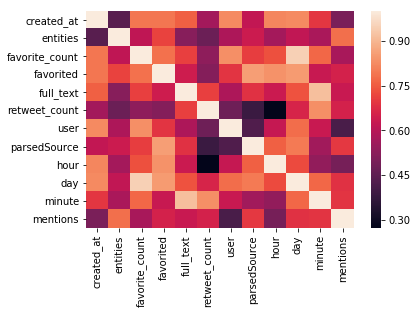

In [58]:
sns.heatmap(lengths.corr())

Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html
for profiling sample code.

"conda install line_profiler" in your environment to utilize the code profiler

In [59]:
%load_ext line_profiler

In [60]:
testMention = {u'hashtags': [],
                u'symbols': [],
               u'urls': [{u'display_url': u'mtech.today/2DsAqjr',
               u'expanded_url': u'https://mtech.today/2DsAqjr',
               u'indices': [97, 120],
               u'url': u'https://t.co/rwauvWY2gy'}],
               
 u'user_mentions': [
     
      {u'id': 747815998531768324L,
       u'id_str': u'747815998531768324',
       u'indices': [3, 17],
       u'name': u'MarTech Today',
       u'screen_name': u'martech_today'},
     
     
      {u'id': 1067019368,
       u'id_str': u'1067019368',
       u'indices': [83, 96],
       u'name': u'Barry Levine',
       u'screen_name': u'xBarryLevine'}
 
 ]}

In [61]:
%lprun -f extractMentions extractMentions(testMention)

"conda install memory_profiler" in your environment to analyze memory usage of imported scripts

In [62]:
%load_ext memory_profiler

In [63]:
%%file extractMentions.py
def extractMentionsScript(entities, remove = ['invoca']):    
    
    mentions = entities['user_mentions']
    numMentions = len(mentions)
    
    names = []
    
    for i in range(numMentions):
        name = mentions[i]['name'].lower()
        
        if name not in remove:
            names += [name]
            
    return names

Overwriting extractMentions.py


In [64]:
from extractMentions import extractMentionsScript

In [65]:
%mprun -f extractMentionsScript extractMentionsScript(testMention)

('',)
